# W207 Final Project: Facial Recognition

### Team: MapReduce, MapReuse, MapRecycle
Members: Tennison Yu, Madeleine Bulkow, Mark Paluta, Alex Dauenhauer

https://github.com/tyu0912/MIDS_W207_facial_recognition/issues

# Introduction

This is the final project submission from Team MapReduce,MapReuse,MapRecycle for W207: Applied Machine Learning as part of the MIDS program at UC Berkeley. We are working with data from https://www.kaggle.com/c/facial-keypoints-detection/data and the goal is to accurately identify facial features on an (x, y) coordinate system based on an input image. 

## Overall Project Flow

Our project is layed out into the following parts:

1) EDA - We explore the data and see what the images and labels we are working with are like

2) Feature Engineering - We alter/augment images to expand our training set to better cover edge cases and generalize the algorithm. Based on our exploration of common standard techniques done, we decided to flip, contrast, blur, and rotate the images.

3) Simple Modeling - We explore the effectiveness of simple algorithms such as Decision Trees and Neast Neighbors and compare and contrast their effectiveness. 

4) Complex Modeling - We explore the effectiveness of a more complex model, convoluted neural networks (CNN).

5) Summary and Apply - We present our findings and apply our best predictive algorithm to the test data that Kaggle provided us to see how well we did. 

# Import Packages, Load data

In [1]:
# # Optional cell to install/update all required packages
# ! pip install keras tensorflow numpy pandas matplotlib scipy imgaug opencv-python pydot graphviz > nul
# print('Packages installed, output supressed for cleanliness')

In [2]:
import time, sys, os, keras, tensorflow as tf, warnings, imgaug as ia
import numpy as np, pandas as pd, matplotlib.pyplot as plt, pydot, graphviz
from importlib import reload
from sklearn.utils import shuffle
from keras import backend as K
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, mean_squared_error
# from sklearn.model_selection import GridSearchCV
from scipy import stats
from imgaug import augmenters as iaa
from datetime import datetime

# set tensorflow as keras backend
if K.backend() not in ["tensorflow", 'plaidml']:
    print ('Switching keras backend...')
    os.environ['KERAS_BACKEND'] = "tensorflow"
    reload(K)
    
print('keras version:', keras.__version__)
print('tensorflow version:', tf.__version__)
print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)

# Initiate settings and load the data.
np.random.seed(0)
pd.options.display.max_columns = 30
warnings.filterwarnings('ignore')

train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')

print ('Everything Loaded Successfully')

Using TensorFlow backend.


keras version: 2.2.4
tensorflow version: 1.12.0
pandas version: 0.23.4
numpy version: 1.15.1
Everything Loaded Successfully


# EDA

We begin by exploring our data. It is important to understand the range of values we can take on, whether there is missing data, and whether there might be erroneous data. We will be exploring primarily on the image level, as opposed to on the individual keypoint or pixel level, because pixels and keypoints tell a much more important story via their relationship to one another rather than in isolation.

## Glancing at the Data

First, we will see the format our data is in. They keypoints are provided in x or y coordinate floats.

In [3]:
train[train.columns[:-1]].head(5)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


The pixels are in a greyscale 8-bit format (range 0 to 255).

In [4]:
train['Image'].head(5)

0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
3    193 192 193 194 194 194 193 192 168 111 50 12 ...
4    147 148 160 196 215 214 216 217 219 220 206 18...
Name: Image, dtype: object

Our first interesting observation is that not all of the images contain all keypoints. In fact no keypoint is present in every image and many are present in less than half of the images. 

In [5]:
print(train.count())

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

From the above cells, we can see that we are given x,y coordinates for our different features in seperate columns. As well, images are currently strings with each pixel value separated by a space. We will need to manipulate these to a form we can work with such as numpy arrays.

Additionally, many labels have a lot of missing data. The only label that is complete appears to be the nose tip.

## Reformating the Data

It seems for complex models such as the CNN, keras requires the data to be in numpy array form with dimensions = (batch, image_width, image_height, num_channels). Images in dataset are 96x96 grayscale images, therefore shape should be (X, 96, 96, 1).

To ensure we have data to work stored away for development, we will also split the training set into 80% train data and 20% dev data in the steps below.

In [6]:
def process_datasets(df, test=False, fillna=False, dropna=False):
    '''This function reformats the data from a dataframe to a numpy
    array of the appropriate shape.
    '''

    # whether or not to remove images with missing labels
    if dropna:
        df = df.dropna()
    
    # build feature dict for reference in future functions
    feature_dict = {label:i for i,label in enumerate(df.columns[:-1].values)}
    
    # separate images into numpy arrays
    images_pixel_feature = df.Image.apply(lambda im: np.fromstring(im, sep=' '))
    
    # rescale pixel values to [0,1] interval and reshape
    images_pixel_feature = np.stack(images_pixel_feature) / 255
    images_pixel_feature = images_pixel_feature.reshape(-1, 96, 96, 1)
    
    
    # separate the labels and scale them to [-1,1] interval for use of 
    # rectified linear unit activation
    if not test:
        facial_point_labels = df.iloc[:, :-1]
        if fillna:
            facial_point_labels.fillna(np.mean(facial_point_labels, axis=0), inplace=True)
        facial_point_labels = facial_point_labels.values
        facial_point_labels = (facial_point_labels - 48) / 48
    else:
        facial_point_labels = None
    
    return images_pixel_feature, facial_point_labels, feature_dict

In [7]:
# Raw data
# train_raw = processed but not split  

train_data_raw, train_labels_raw, feature_dict = process_datasets(train)

test_data, test_labels, _ = process_datasets(test, test=True)

### Removing erroneous data  
We noticed that some data seems to be erroneous. We utilized a method that will be covered in our appendix to flag likely erroneous images. They are printed here to confirm that they indeed look erroneous, and then we throw them out for the remainder of our project.

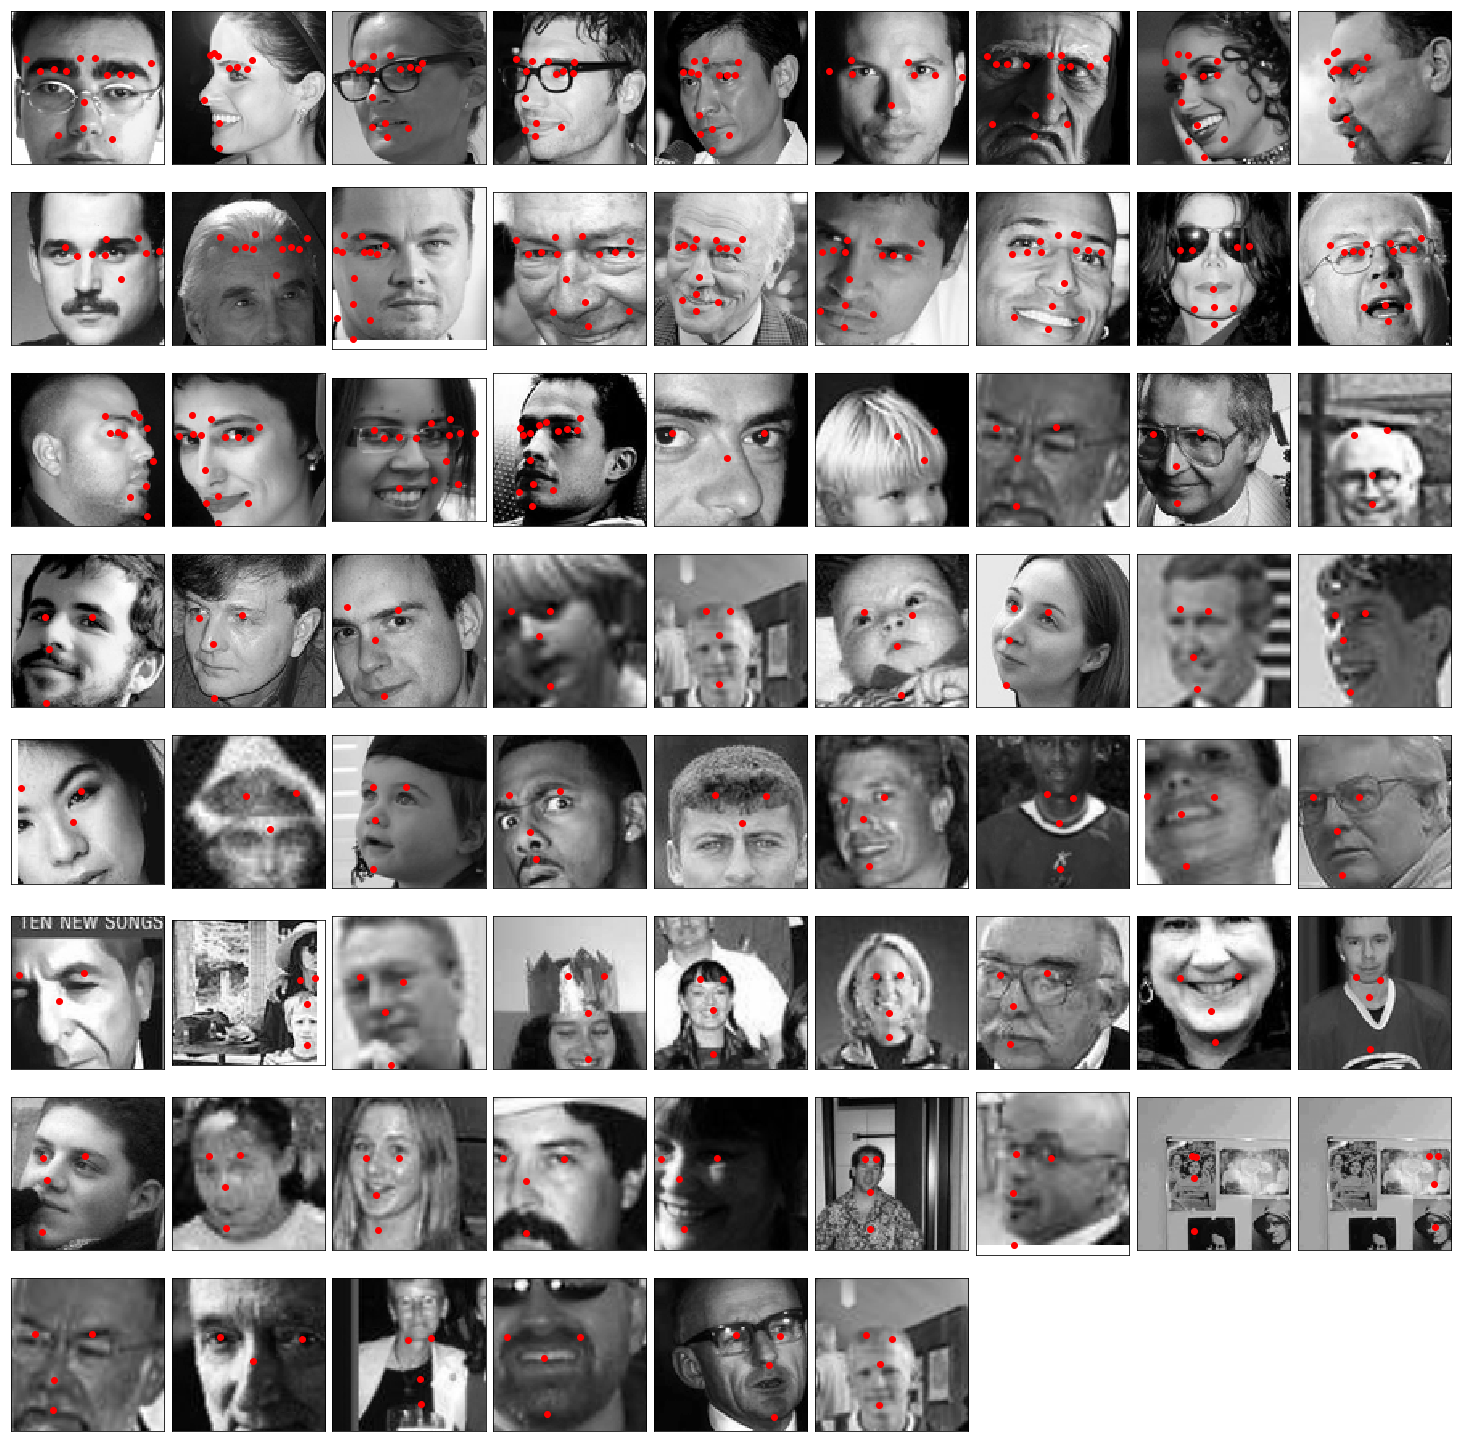

In [8]:
# hard code in flagged images
flagged = [1230, 1620, 1649, 1652, 1723, 1747, 1808, 1834, 1861, 1877, 1881, 1907, 1927, 1942, 1966, 1995,
           2036, 2096, 2175, 2191, 2199, 2244, 2289, 2453, 2484, 2533, 2562, 2629, 2664, 2700, 2787, 2818,
           2831, 2845, 2982, 3087, 3173, 3296, 3307, 3374, 3447, 3487, 3510, 3647, 3888, 4180, 4263, 4480,
           4482, 4490, 4601, 4717, 4786, 5117, 5795, 5952, 6082, 6271, 6315, 6405, 6407, 6492, 6493, 6569,
           6585, 6765, 6782, 6834, 6906]

# plot these images as a sanity check that they are in fact "bad" data
i = 0
rows = 8
cols = len(flagged)//rows + 1
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for index in flagged:
    ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])
    ax.imshow(train_data_raw[index].reshape(96,96), cmap='gray')
    ax.scatter(train_labels_raw[index][0::2] * 48 + 48, train_labels_raw[i][1::2] * 48 + 48, c='r')
    i += 1

# Delete these images from the data set forever
train_data_raw = np.delete(train_data_raw, flagged, 0)
train_labels_raw = np.delete(train_labels_raw, flagged, 0)

Because there are so many images with incomplete values, we define another set with NA removed just in case. 

In [9]:
# Dropping NAs
# train_complete = no missing values  

train_data_complete, train_labels_complete, _ = process_datasets(train, dropna=True)

In [10]:
### DON'T RUN THIS CELL MORE THAN ONCE WITHOUT RE-RUNNING PROCESS DATASETS! ###

# 20% of the data will go to dev
percent_to_dev = 0.2 

# Note the naming convention change.
# train_orig = with missing values  

train_data_orig, dev_data_orig, train_labels_orig, dev_labels_orig = train_test_split(
    train_data_raw, train_labels_raw, test_size=percent_to_dev
)
train_data_complete, dev_data_complete, train_labels_complete, dev_labels_complete = train_test_split(
    train_data_complete, train_labels_complete, test_size=percent_to_dev
)

print("\nTrain data shape", train_data_orig.shape)
print("Dev data shape", dev_data_orig.shape)
print("Train labels shape", train_labels_orig.shape)
print("Dev labels shape", dev_labels_orig.shape)
print("\nTrain data no-missing-values shape", train_data_complete.shape)
print("Dev data no-missing-values shape", dev_data_complete.shape)
print("Train labels no-missing-values shape", train_labels_complete.shape)
print("Dev labels no-missing-values shape", dev_labels_complete.shape)

print("\nData Generation Finished")


Train data shape (5584, 96, 96, 1)
Dev data shape (1396, 96, 96, 1)
Train labels shape (5584, 30)
Dev labels shape (1396, 30)

Train data no-missing-values shape (1712, 96, 96, 1)
Dev data no-missing-values shape (428, 96, 96, 1)
Train labels no-missing-values shape (1712, 30)
Dev labels no-missing-values shape (428, 30)

Data Generation Finished


## Examine Random Sample

Here we wanted to observe some sample images with labels to see what kind of variety of images we are working with. 

In [11]:
def plot_sample(data, labels, labels2=None):
    '''
    data must be a numpy.ndarray of shape (X, 96, 96, 1)
    labels must be a numpy.ndarray (X, 30)
    X must be any square number
    labels = true labels
    labesl2 = predicted labels (optional)
    '''
    
    dim = np.sqrt(len(data))
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(len(labels)):
        img = data[i].reshape(96,96)
        ax = fig.add_subplot(dim, dim, i + 1, xticks=[], yticks=[])
        ax.imshow(data[i].reshape(96,96), cmap='gray')
        ax.scatter(labels[i][0::2] * 48 + 48, labels[i][1::2] * 48 + 48, c='r')
        if not labels2 is None:
            ax.scatter(labels2[i][0::2] * 48 + 48, labels2[i][1::2] * 48 + 48, c='b')

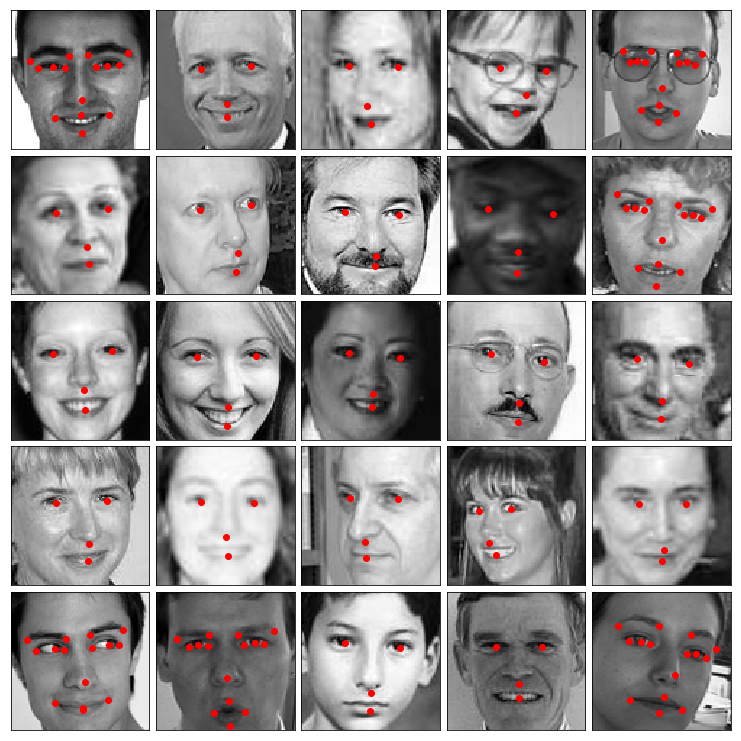

In [12]:
# Output sample of random images. Some of these will be the NA data
n = 25
idx = np.random.randint(0, len(train_data_raw), n)
data_sample = train_data_raw[idx, :, :, :]
label_sample = train_labels_raw[idx, :]
plot_sample(data_sample, label_sample)

As can be seen, there is great diversity in the images that we are working with. Not all are frontal shots as some of the heads are angled and tilted. Some of the images are also more blured/sharp, some are darker/lighter and some are wearing glasses. We can also confirm from above that many images do not possess a complete set of labels. 

## Examine Edge Cases

In addition to random faces, we wondered what some edge cases are like. 

In [13]:
edge_cases = []

# compile interesting cases
edge_cases.extend(train_labels_raw[:,feature_dict['nose_tip_x']].argsort()[:10])           # noses near left of screen
edge_cases.extend(train_labels_raw[:,feature_dict['nose_tip_x']].argsort()[-10:])          # noses near right of screen
edge_cases.extend(train_labels_raw[:,feature_dict['nose_tip_y']].argsort()[:10])           # noses near top of screen
edge_cases.extend((train_labels_raw[:,feature_dict['right_eye_center_x']] -
                   train_labels_raw[:,feature_dict['left_eye_center_x']]).argsort()[:10])  # wide faces
edge_cases.extend((train_labels_raw[:,feature_dict['right_eye_center_x']] -
                   train_labels_raw[:,feature_dict['left_eye_center_x']]).argsort()[-9:]) # small faces

print(len(edge_cases), edge_cases)

data_edge = train_data_raw[edge_cases, :, :, :]
label_edge = train_labels_raw[edge_cases, :]

49 [3112, 4946, 6935, 2269, 3253, 6498, 3810, 6852, 4874, 3510, 1584, 1913, 1914, 2094, 2007, 3487, 2632, 2563, 3151, 2058, 466, 329, 503, 648, 113, 493, 530, 272, 178, 92, 6791, 2545, 2746, 3116, 5113, 3513, 4398, 5009, 2657, 4723, 2082, 2081, 2078, 1925, 1900, 1857, 1683, 2119, 2073]


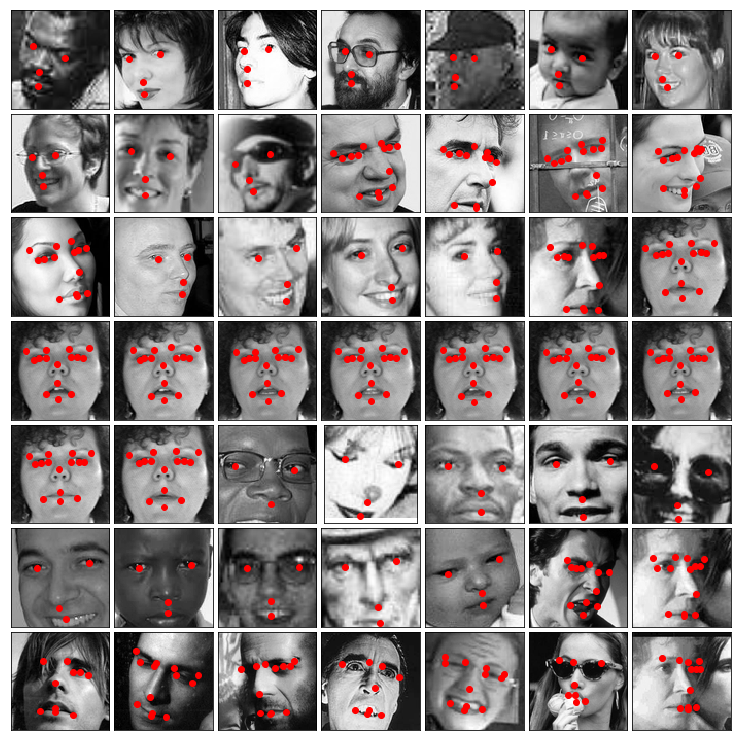

In [14]:
plot_sample(data_edge, label_edge)

From the above, it looks like there are several different types of edge cases. Some images have features obscured (hair over eyes, sunglasses, etc) and therefore are missing labels. Some cases look like purely bad data that may need to be removed such as the first picture of Leonardo DiCarpio and the image 18, the collection of pictures. Also interesting is that there are images that are very similar. For instance, image 28, 29, 30 all seem to be the same woman but in image 28 her mouth is closed, and image 29 is a little darker than image 30. 

# Data Engineering

To be sure we can capture some of these edge cases, we expand the variety of our data set even more. We decided to create sets of images that were mirrored, contrasted, blurred, and rotated as it seems these are the most prevalent gestures of the different faces. 

## Perform Augmentations

In [15]:
# We use the imgaug library to generate our new sets of images

def augment_images(data, labels, aug):
    
    data = data * 255
    aug_labels =[]
    seq_det = aug.to_deterministic()
    aug_data = seq_det.augment_images(data)
    
    keypoints_on_images = []
    
    for features in labels:
        keypoints = []
        
        for c in range(0, features.shape[0], 2):
            x = features[c]* 48 + 48
            y = features[c+1]* 48 + 48

            keypoints.append(ia.Keypoint(x=x, y=y))

        keypoints_on_images.append(ia.KeypointsOnImage(keypoints, shape=(96,96)))
    
    keypoints_aug = seq_det.augment_keypoints(keypoints_on_images)    
        
    for keypoints_after in keypoints_aug:
        aug_labels_set = []
        
        for i, keypoint in enumerate(keypoints_after.keypoints):
            aug_labels_set.append((keypoint.x - 48) / 48)
            aug_labels_set.append((keypoint.y - 48) / 48)
                
        aug_labels.append(aug_labels_set)
        
    return aug_data/255, np.array(aug_labels)

# The imgaug library confuses the labels in the case of mirroring an image so we made our own custom method. 

def mirror_data(data, labels, features):
    '''This function flips the images and labels to their new columns
    Input data is numpy array of shape (X, 96, 96, 1)
    Input labels is numpy array of shape (X, 30)
    features is a list of column header strings
    '''
    
    # flip the images
    data_flipped = data[:, :, ::-1, :]
    
    # flip the labels
    labels_flipped = np.zeros(labels.shape)
    for idx in range(len(labels)):
        for i,s1 in enumerate(features):
            parts = s1.partition('_')
            if parts[0] == 'left' or parts[0] == 'right':
                coord = parts[-1]
            elif parts[0] == 'mouth':
                parts = s1.split('_', maxsplit=2)
                if 'corner' in parts[-1]:
                    coord = parts[-1]        
                elif 'x' in parts[-1]:
                    labels_flipped[idx,i] = labels[idx,i] * -1
                else:
                    labels_flipped[idx,i] = labels[idx,i]
            else:
                if 'x' in parts[-1]:
                    labels_flipped[idx,i] = labels[idx,i] * -1
                else:
                    labels_flipped[idx,i] = labels[idx,i]
            for j in range(i+1,len(features)-1):
                s2 = features[j]
                if coord in s2:
                    if 'x' in coord:
                        labels_flipped[idx,i] = labels[idx,j] * -1
                        labels_flipped[idx,j] = labels[idx,i] * -1
                    else:
                        labels_flipped[idx,i] = labels[idx,j]
                        labels_flipped[idx,j] = labels[idx,i]
                
    return data_flipped, labels_flipped

In [16]:
# mirror training and dev data
flipped_data, flipped_labels = mirror_data(
    train_data_orig, train_labels_orig, list(feature_dict.keys())
)

flipped_data_complete, flipped_labels_complete = mirror_data(
    train_data_complete, train_labels_complete, list(feature_dict.keys())
)

# Concatanating to make new set

# Note the new naming convention
# train_aug = augmented with missing values  
# train_aug_comp = augmented no missing values

train_data_aug = np.concatenate((train_data_orig,flipped_data), axis=0)
train_labels_aug =  np.concatenate((train_labels_orig, flipped_labels), axis=0)

train_data_aug_comp = np.concatenate((train_data_complete, flipped_data_complete),axis=0)
train_labels_aug_comp = np.concatenate((train_labels_complete,flipped_labels_complete),axis=0)

In [17]:
# We apply 1,2 or 3 of blurring, contrast, and rotation to 50% of the data. 
# We do this randomly to make sure everything is equally distributed.

aug = iaa.Sometimes(0.5,  iaa.SomeOf((1, 3), 
            [iaa.GammaContrast((0.25, 3)),
             iaa.GaussianBlur(sigma=1),
             iaa.Affine(rotate=(-10,10), scale={"x": (1.05, 1.2), "y": (1.05, 1.2)})
            ]                        
        )
    )


train_data_aug, train_labels_aug = augment_images(train_data_aug, train_labels_aug, aug)
train_data_aug_comp, train_labels_aug_comp = augment_images(train_data_aug_comp, train_labels_aug_comp, aug)


## Plot Sample Augmentation

In [18]:
img1 = train_data_orig[0].reshape(96,96)
lab1 = train_labels_orig[0]
img2 = train_data_aug[0].reshape(96,96)
lab2 = train_labels_aug[0]
img3 = train_data_orig[1].reshape(96,96)
lab3 = train_labels_orig[1]
img4 = train_data_aug[1].reshape(96,96)
lab4 = train_labels_aug[1]
img5 = train_data_orig[2].reshape(96,96)
lab5 = train_labels_orig[2]
img6 = train_data_aug[2].reshape(96,96)
lab6 = train_labels_aug[2]

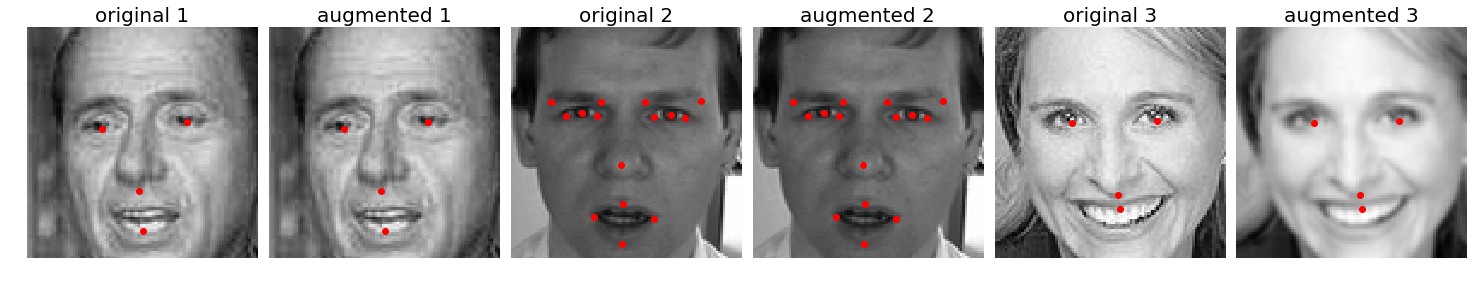

In [19]:
imgs = [img1, img2, img3, img4, img5, img6]
labs = [lab1, lab2, lab3, lab4, lab5, lab6]
titles = ['original 1','augmented 1','original 2','augmented 2','original 3', 'augmented 3']

fig, axes = plt.subplots(1,6,figsize=(20,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(6):
    ax = axes[i]
    ax.imshow(imgs[i], cmap='gray')
    ax.scatter(labs[i][0::2] * 48 + 48, labs[i][1::2] * 48 + 48, c='r')
    ax.axis('off')
    ax.set_title(titles[i], fontsize=20)

Looking at the 5 images above, it looks like the rotations worked well

# Establish Baseline

In [20]:
# Instatiate a dictionary to keep results in
result_dict = {}

## Simple Models

In [21]:
# no missing values
avg_position = np.mean(train_labels_complete, axis=0)
predictions = np.ones(train_labels_complete.shape) * avg_position
mse = np.sqrt(mean_squared_error(train_labels_complete, predictions)) * 48
result_dict['Training Average'] = [None, None, None, predictions]
mse

3.1629511112184683

Add in training loss, (predict on self), capture runtime

In [22]:
# More simple baselines
regressors = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(), # Maddie
    'NearestNeighbors': KNeighborsRegressor(), # Tennison
} 

def model_training(model, train_data, labels, dev_data, dev_labels):
    X = train_data.reshape(-1, 96**2)
    Y = labels
    
    start=datetime.now()
    model.fit(X,Y)
    runtime = datetime.now() - start
    
    predictions = model.predict(X)
    train_mse = np.sqrt(mean_squared_error(Y, predictions)) * 48
    
    Z = dev_data.reshape(-1, 96**2)
        
    predictions = model.predict(Z)
    dev_mse = np.sqrt(mean_squared_error(dev_labels, predictions)) * 48
    
    return [train_mse, dev_mse, runtime, predictions]


This is with the complete set

 LinearRegression :
 Training RMSE= 0.0 Dev RMSE= 2.75 Train Time= 2

 DecisionTree :
 Training RMSE= 0.0 Dev RMSE= 3.65 Train Time= 21

 NearestNeighbors :
 Training RMSE= 1.94 Dev RMSE= 2.62 Train Time= 0


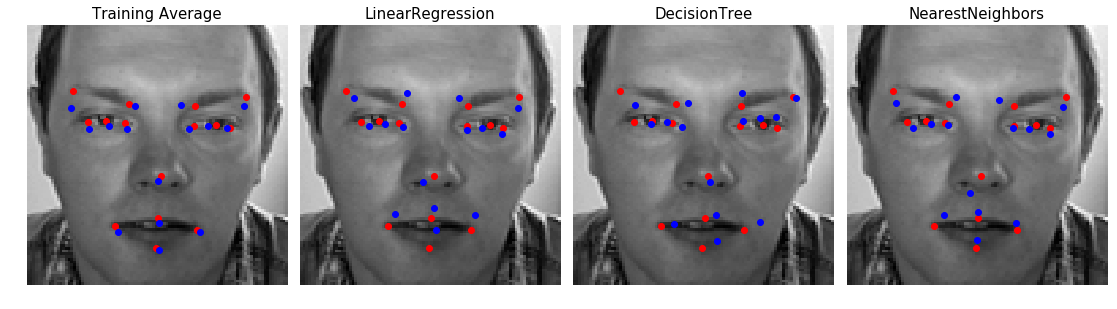

In [23]:
def train_basic_models(which_set, train_data, train_labels, dev_data, dev_labels):
    if which_set == 'complete':
        print ('This is with the complete set')
    elif which_set == 'complete_aug':
        print ('This is with the complete_aug set')
    
    for k,v in regressors.items():
        result = model_training(v, train_data, train_labels, dev_data, dev_labels)

        result_dict[k] = result
        print('\n', k,':\n',
              'Training RMSE=', round(result[0],2),
              'Dev RMSE=', round(result[1],2),
              'Train Time=', round(result[2].seconds,2)
             )

    img_idx = 2
    img = train_data_complete[img_idx].reshape(96,96)

    fig, axes = plt.subplots(1,len(result_dict),figsize=(15,15))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i,(k,v) in enumerate(result_dict.items()):
        ax = axes[i]
        ax.imshow(img, cmap='gray')
        ax.scatter(train_labels_complete[img_idx][0::2] * 48 + 48, train_labels_complete[img_idx][1::2] * 48 + 48, c='r')
        ax.scatter(v[3][img_idx][0::2] * 48 + 48, v[3][img_idx][1::2] * 48 + 48, c='b')
        ax.axis('off')
        ax.set_title(k, fontsize=15)
    
train_basic_models('complete', train_data_complete, train_labels_complete, dev_data_complete, dev_labels_complete)

In [24]:
# This was commented out due to training time. 
# train_basic_models('complete_aug', train_data_aug_comp, train_labels_aug_comp, dev_data_aug_comp, dev_labels_aug_comp)

### Linear Regression

**Rational:** This was picked because of its simplicity and we just wanted to see what it would like with a classical method

**Weakness:** Although coming out with a decent RMSE in this case, after running this step with augmented data as well, the value becomes much higher. It was 1,903,779 vs 2.63 the last time it ran. This shows that the method does a poor job at learning when there is extreme variation in the labels and the images they map to. Therefore, it is likely not reliable as an algorithm moving forward

### Decision Tree - Maddie

In [25]:
# placeholder

### KNN 

**Rational:** We pick kNN because all facial features are on the same location on the face i.e left eye is on the upper left, right eye is on the upper right, nose is in the middle, etc. Given a set of images, kNN should be able to figure out which pixels is generally associated with the eye area, the nose area, etc.

**Weakness:** One potential weakness of this algorithm may be images where the head is tilted or located off center. For example, if an image has a face translated to the right, then it may mistake the left eye on the image for a right eye

# Convolutional Neural Network

## Building the CNN

**Parameter and Hyper-parameter selection:**

The Convolutional Neural Network (CNN) has many parameters to choose to build the model. We first need to determine how many layer stacks the model should have. Each layer stack should contain, at a minimum, a convolutional layer and a pooling layer. You can also choose to add a dropout layer at each stack, to help avoid overfitting on the training set.  For each convolutional layer, we need to determine the shape of the convolutional kernel, as well the shape of the pooling kernel. After the convolutional layer stack, the output needs to be flattened and we need to determine the number of dense layers to send it through before generating the output. Again we can choose to add dropout layers here or not. After we have decided on the shape our network will take, we need to determine the optimizer to use, and the loss function. The optimizer comes with its own set of hyperparameters, the most important of which is the initial learning rate according to Bengio.

**Optimizer:**  
Per Bengio, for stochastic gradient descent (SGD) optimization, "The optimal learning rate is usually close to the largest learning rate that does not cause divergence of the training criterion." His suggestion is to start with a large learning rate and if the training criterion diverges, decrease the learning rate by a factor of 3. Due to hardware memory limitations, we were unable to carry out full hyperparameter tuning via grid search. So rather than search for the optimal SGD learning rate, we chose to use an adaptive optimizer called Adam which converges much faster than standard SGD. Adam is an adaptation/enhancement to SGD. Whereas SGD uses a single learning rate for all weight updates and does not update the learning rate during training, the Adam optimizer "calculates an exponential moving average of the gradient and the squared gradient." The hyperparameters beta1 and beta2 control the decay rates of these moving averages. Because the authors of the Adam optimizer performed hyperparameter tuning on a similar convolutional neural net built for prediction on the MNIST data set, we used the default values of the Adam optimizer which are currently set to the optimal values determined by the authors.

**Number of Layers:**  
Again according to Bengio, "the optimal number layers can be determine by simply adding layers until the error does not improve anymore." As we were using the Daniel Nouri tutorial as a guide to building the CNN, we started with three convolutional/pooling layer pairs in our CNN. We tested 4 and 5 layer pairs as well which gave little to no improvement in the loss on the validation data, but did increase the training time significantly, so we decided on three layer pairs for the default value of the model. 

**Number of filters:**
Each filter in a convolutional layer can be thought of as a single feature detector. In the initial layer, the filters will be able to detect simple geometric patterns such as a lines or curves. As we go deeper in the network, the feature detectors can become more sophisticated. Since we want to predict the position of 15 facial keypoints varying in shape and size and orientation, we need to have enough feature detectors by the last layer to handle a large variety of features. We tried various combinations of factors of 2 for the number of filters in each layer, with the number of filters multiplying by 2 at each layer. After some trial and error, we settled on 32, 64, 128 filters for convolutional layers 1, 2, and 3 respectively. 

**Pooling layers:**  
The pooling layers determine the factor by which you downscale your data after each convolutional layer. We chose to simply use pooling kernels of (2,2) with a stride of (2,2) so that our output shape at each layer was easy to keep track of

**Number of Dense layers and Dense layer nodes:**  
Admittedly, we spent more of our time tuning the parameters in the convolutional stack than in the dense layer section of the model, but we did test some variations ranging from 1 layer with 100 nodes to 3 layers of 2000 nodes and ended up settling on 2 layers with 1000 nodes each for our default model values.


**Build a custom loss function to handle NA values**

In [26]:
# building a time callback to track total runtime
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [27]:
# building a custom loss function to handle NAs
def mean_squared_error_with_missing(y_true, y_pred):
    
    # figure out which labels are present
    present = tf.logical_not(tf.is_nan(y_true))
    
    # select only those labels
    present_labels_true = tf.boolean_mask(y_true, present)
    present_labels_pred = tf.boolean_mask(y_pred, present)
    
    # compute mean squared error
    loss = tf.math.reduce_mean(tf.math.squared_difference(present_labels_true,present_labels_pred))
    
    return loss

**Build the model**

How we built the model:  
We had to decide on the default hyperparameters for our CNN model 

In [28]:
def build_CNN(
    num_ConvLayers=3, 
    num_DenseLayers=2,
    filters=[32,64,128],
    kernels=[(3,3),(3,3),(3,3)], 
    pools=[(2,2),(2,2),(2,2)], 
    dense_nodes=[1000,1000], 
    optimizer='Adam', 
    dropout=None,
    input_shape=(96,96,1),
    loss=mean_squared_error_with_missing
):
    '''This function builds a CNN model
    num_ConvLayers --> is the number of convolutional layer groups where 
    each group contains a convolutional layer, a pooling layer, and an
    optional dropout layer
    
    num_DenseLayers --> is the number of dense layers after flattening
    the convolutional output
    
    filters --> a list of the number of filters used in each
    convolutional layer specified in num_ConvLayers
    
    kernels --> a list of the kernel size to use in each convolutional
    layer specified in num_ConvLayers
    
    pools --> a list of the kernel size to use in each pooling layer
    specified in num_ConvLayers
    
    dense_nodes --> a list of the number of units in each dense layer
    specified in num_DenseLayers
    
    dropout --> optional, a list of the dropout rates at each 
    convolutional layer
    
    input_shape --> the shape of the input data
    '''
    # define a Sequential model
    model = Sequential()
    
    # add convolutional layer groups
    for i in range(num_ConvLayers):
        model.add(Conv2D(
            filters=filters[i],
            kernel_size=kernels[i],
            strides=(1,1),
            padding='same',
            activation='relu',
            input_shape=input_shape
        ))
        model.add(MaxPooling2D(
            pool_size=pools[i],
            strides=None
        ))
        
        # add dropout layers if specified
        if dropout:
            model.add(Dropout(rate=dropout[i]))
    
    # flatten the convolutional layers
    model.add(Flatten())
    
    # add the dense layers
    for j in range(num_DenseLayers):
        model.add(Dense(
            units=dense_nodes[j],
            activation='relu'
        ))
        
    # create the output layer
    model.add(Dense(units=30))
    
    # compile the model
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

**Train the model**

In [29]:
def train_model(
    model, 
    train_data, train_labels, 
    dev_data=None, dev_labels=None,
    batch_size=32,
    verbose=1,
    epochs=10
):
    time_callback = TimeHistory()
    hist = keras.callbacks.History()
    if not dev_data is None:
        model.fit(
            train_data, train_labels, 
            batch_size=batch_size,
            epochs=epochs, 
            validation_data=(dev_data, dev_labels),
            verbose=verbose,
            callbacks=[hist, time_callback]
        )
    else:
        model.fit(
            train_data, train_labels, 
            batch_size=batch_size,
            epochs=epochs, 
            validation_split=0.2,
            verbose=verbose,
            callbacks=[hist, time_callback]
        )
    print('\nRMS error on validation set:', np.sqrt(hist.history['val_loss'][-1]) * 48)
    print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))
    
    return hist, time_callback

**Visualize the model**

In [30]:
def plot_NN(model):
    plot_model(model, to_file='model.png', show_shapes=True)
    mod = plt.imread('model.png')
    fig = plt.figure(figsize=(10,20), frameon=False)
    plt.imshow(mod)
    plt.axis('off')

###  Running CNN
I think we discussed building a CNN with a set of default parameters, train it on the original data set, then augment the data and train it again, then change some parameters in the model and train it again, etc

<table> 
<tr>
<th> Model Name </th> <th> Model Parameters </th> <th> Training Criteria </th>
</tr>
<tr>
<td> Model 1 </td> <td> Default </td> <td> 10 epochs, original data </td>
</tr>
    <tr>
<td> Model 2 </td> <td> Default </td> <td> 10 epochs, augmented data </td>
</tr>
    <tr>
<td> Model 3 </td> <td> Default </td> <td> 10 epochs, augmented data w/ NA's filled by predicted values </td>
</tr>
    <tr>
</tr>
</table>

#### Model 1

In [23]:
model1 = build_CNN()

In [ ]:
plot_NN(model1)

In [24]:
hist1, runtime1 = train_model(
    model1, train_data_orig, train_labels_orig, 
    dev_data_orig, dev_labels_orig, epochs=40
)

result_dict['CNN Model1'] = [
    round(np.sqrt(hist1.history['loss'][-1]) * 48,2), 
    round(np.sqrt(hist1.history['val_loss'][-1]) * 48,2),
    round(np.sum(runtime1.times),2)
]

Train on 5584 samples, validate on 1396 samples
Epoch 1/40
5584/5584 [==============================] - 19s 3ms/step - loss: 0.0085 - val_loss: 0.0037
Epoch 2/40
5584/5584 [==============================] - 18s 3ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 3/40
5584/5584 [==============================] - 18s 3ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 4/40
5584/5584 [==============================] - 18s 3ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 5/40
5584/5584 [==============================] - 18s 3ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 6/40
5584/5584 [==============================] - 18s 3ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 7/40
5584/5584 [==============================] - 18s 3ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 8/40
5584/5584 [==============================] - 18s 3ms/step - loss: 9.2630e-04 - val_loss: 0.0015
Epoch 9/40
5584/5584 [==============================] - 18s 3ms/step - loss: 8.3431e-04 - val_loss: 0.0014
Epoch 10/40
5584/

KeyboardInterrupt: 

In [34]:
history1 = pd.DataFrame(hist1.history)
history1.to_csv('hist1.csv')

We could try running this for longer, but the way the validation loss levels off even as the training loss continues to shrink shows that the model is overfitting. This is unsurprising given the small size of our data set, and the large number of parameters. For better results, we should next try the full (unaugmented) data set and see how it fares.

#### Model 2

In [ ]:
model2 = build_CNN()

In [ ]:
hist2, runtime2 = train_model(
    model2, train_data_aug, train_labels_aug, 
    dev_data_orig, dev_labels_orig, epochs=40
)

result_dict['CNN Model2'] = [
    round(np.sqrt(hist2.history['loss'][-1]) * 48,2), 
    round(np.sqrt(hist2.history['val_loss'][-1]) * 48,2), 
    round(np.sum(runtime2.times),2)
]

In [37]:
history2 = pd.DataFrame(hist2.history)
history2.to_csv('history2.csv')

This did significantly better and the validation loss was still improving alongside the training loss at the end of ten epochs. Given this continued improvement, it would be worth running this for longer.

### Predict missing values
A large percentage of the points are missing, meaning we are not using a large percentage of the information we have in the dataset. However facial keypoints will, in general, follow location patterns across images of faces. Uing a simple two layer neural net we use the moset commonly labeled key points to predict values for the features that are not labeled in a majority of the data. Then we can fill the missing labels in with these predicted points and retrain the data with no missing values

### 2-layer Neural Net

#### Visualize training improvement
Doesn't look like an improvement, but it will once we train on the whole data sets

In [ ]:
val_rms1 = h1['val_loss']
train_rms1 = h1['loss']
val_rms2 = h2['val_loss']
train_rms2 = h2['loss']

plt.semilogy(val_rms1, 'g-')
plt.semilogy(train_rms1, 'g--')
plt.semilogy(val_rms2, 'b-')
plt.semilogy(train_rms2, 'b--')
plt.legend([
    'val loss - model 1','training loss - model 1',
    'val loss - model 2','training loss - model 2'
])

### Build the 2-layer NN

In [31]:
basicNN = Sequential()
basicNN.add(Dense(units=1000,activation='relu'))
basicNN.add(Dense(units=1000,activation='relu'))
basicNN.add(Dense(units=1000,activation='relu'))

# create the output layer
basicNN.add(Dense(units=30))

# compile the model
# basicNN.compile(loss='mean_squared_error', optimizer='Adam')
basicNN.compile(loss=mean_squared_error_with_missing, optimizer='Adam')

In [32]:
NN_hist, NN_time = train_model(
    basicNN,
    train_labels_aug_comp[:,[0,1,2,3,20,21,28,29]], train_labels_aug_comp,
    epochs=20
)

Train on 2739 samples, validate on 685 samples
Epoch 1/20
2739/2739 [==============================] - 3s 1ms/step - loss: 0.0101 - val_loss: 0.0021
Epoch 2/20
2739/2739 [==============================] - 1s 301us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/20
2739/2739 [==============================] - 1s 303us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/20
2739/2739 [==============================] - 1s 304us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/20
2739/2739 [==============================] - 1s 303us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/20
2739/2739 [==============================] - 1s 301us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/20
2739/2739 [==============================] - 1s 308us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/20
2739/2739 [==============================] - 1s 301us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 9/20
2739/2739 [==============================] - 1s 302us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/20
2739/27

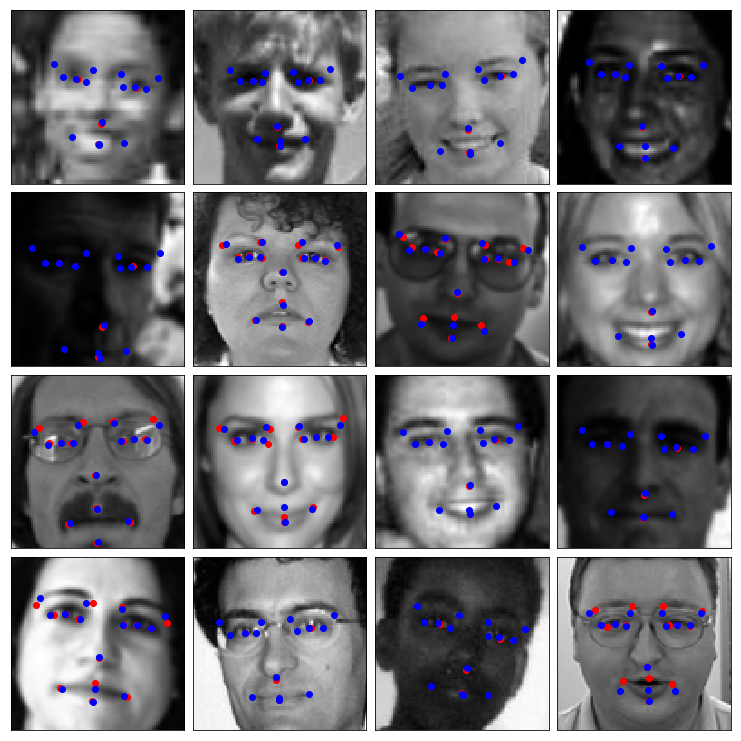

In [33]:
idx = np.random.randint(0, len(train_data_aug), 16)
data_sample = train_data_aug[idx, :, :, :]

pred = basicNN.predict(train_labels_aug[:,[0,1,2,3,20,21,28,29]])

label_sample = pred[idx, :]
label_sample_true = train_labels_aug[idx, :]

plot_sample(data_sample, label_sample_true, labels2=label_sample)

In [34]:
train_labels_full = train_labels_aug.copy()
for i in range(train_labels_full.shape[1]):
    for j,v in enumerate(train_labels_full[:,i]):
        if np.isnan(v):
            train_labels_full[j,i] = pred[j,i]

#### Model 3

In [37]:
# augment some data or change a parameter
model3 = build_CNN()

In [ ]:
plot_NN(model3)

Testing against augmented dev data with missing values

In [38]:
hist3, runtime3 = train_model(
    model3, train_data_aug, train_labels_full, 
    dev_data_orig, dev_labels_orig, epochs=400
)
history3 = pd.DataFrame(hist3.history)
history3.to_csv('history3.csv')
result_dict['CNN Model3'] = [
    round(np.sqrt(hist3.history['loss'][-1]) * 48,2), 
    round(np.sqrt(hist3.history['val_loss'][-1]) * 48,2), 
    round(np.sum(runtime3.times),2)
]

Train on 11168 samples, validate on 1396 samples
Epoch 1/400
11168/11168 [==============================] - 36s 3ms/step - loss: 12664.6854 - val_loss: 0.0063
Epoch 2/400
11168/11168 [==============================] - 35s 3ms/step - loss: 0.1209 - val_loss: 0.0056
Epoch 3/400
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0215 - val_loss: 0.0054
Epoch 4/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 5/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0073 - val_loss: 0.0050
Epoch 6/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0064 - val_loss: 0.0048
Epoch 7/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0058 - val_loss: 0.0048
Epoch 8/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 9/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0054 - val_loss: 

11168/11168 [==============================] - 35s 3ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 78/400
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 79/400
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 80/400
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 81/400
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 82/400
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 83/400
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 84/400
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 85/400
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 86/400
11168/11168 [========================

11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 154/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 155/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 156/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 157/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 158/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 159/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 160/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 161/400
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 162/400
11168/11168 [===============

Epoch 229/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 230/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 231/400
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 232/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 233/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 234/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 235/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 236/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 237/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 238/400
11168/11168 [=

Epoch 305/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 306/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 307/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 308/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 309/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 310/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 311/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 312/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 313/400
11168/11168 [==============================] - 36s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 314/400
11168/11168 [=

Epoch 381/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 382/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 383/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 384/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 385/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 386/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 387/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 388/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 389/400
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 390/400
11168/11168 [=

In [39]:
# augment some data or change a parameter
model4 = build_CNN(dropout=[0.3,0.3,0.3])

In [ ]:
plot_NN(model4)

Testing against augmented dev data with missing values

In [40]:
hist4, runtime4 = train_model(
    model4, train_data_aug, train_labels_full, 
    dev_data_orig, dev_labels_orig, epochs=400
)
history4 = pd.DataFrame(hist4.history)
history4.to_csv('history4.csv')
result_dict['CNN Model4'] = [
    round(np.sqrt(hist4.history['loss'][-1]) * 48,2), 
    round(np.sqrt(hist4.history['val_loss'][-1]) * 48,2), 
    round(np.sum(runtime3.times),2)
]

Train on 11168 samples, validate on 1396 samples
Epoch 1/400
11168/11168 [==============================] - 39s 3ms/step - loss: 9445.2440 - val_loss: 0.0064
Epoch 2/400
11168/11168 [==============================] - 37s 3ms/step - loss: 1.4421 - val_loss: 0.0061
Epoch 3/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.4409 - val_loss: 0.0058
Epoch 4/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0644 - val_loss: 0.0059
Epoch 5/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0365 - val_loss: 0.0062
Epoch 6/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0310 - val_loss: 0.0059
Epoch 7/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0365 - val_loss: 0.0098
Epoch 8/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0374 - val_loss: 0.0059
Epoch 9/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0346 - val_loss: 0

11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 78/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 79/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 80/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 81/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 82/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 83/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 84/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 85/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 86/400
11168/11168 [========================

11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 154/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 155/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 156/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 157/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 158/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 159/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 160/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 161/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 162/400
11168/11168 [===============

11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 229/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 230/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 231/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 232/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 233/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 234/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 235/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 236/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 237/400
11168/11168 [===============

11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 304/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 305/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 306/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 307/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 308/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 309/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 310/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 311/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 312/400
11168/11168 [===============

Epoch 379/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 380/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 381/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 382/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 383/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 384/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 385/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 386/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 387/400
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 388/400
11168/11168 [=

#### Visualize training improvement
Doesn't look like an improvement, but it will once we train on the whole data sets

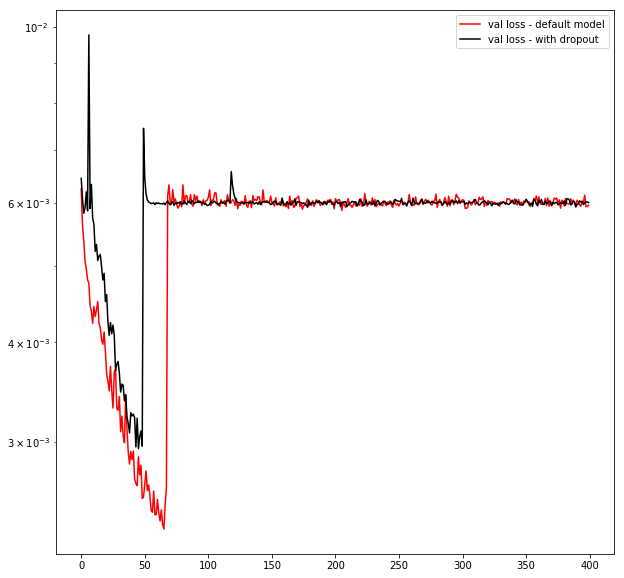

In [43]:
# val_rms1 = hist1.history['val_loss']
# train_rms1 = hist1.history['loss']
# val_rms2 = hist2.history['val_loss']
# train_rms2 = hist2.history['loss']
val_rms3 = hist3.history['val_loss']
train_rms3 = hist3.history['loss']
val_rms4 = hist4.history['val_loss']
train_rms4 = hist4.history['loss']
fig, ax = plt.subplots(figsize=(10,10))
# plt.semilogy(val_rms1, 'g-')
# plt.semilogy(train_rms1, 'g--')
# plt.semilogy(val_rms2, 'b-')
# plt.semilogy(train_rms2, 'b--')
ax.semilogy(val_rms3, 'r-')
# plt.semilogy(train_rms3, 'r--')
ax.semilogy(val_rms4, 'k-')
# plt.semilogy(train_rms4, 'k--')

# plt.legend([
# #     'val loss - model 1','training loss - model 1',
# #     'val loss - model 2','training loss - model 2',
#     'val loss - model 3','training loss - model 3',
#     'val loss - model 4','training loss - model 4'
# ])
ax.legend([
#     'val loss - model 1','training loss - model 1',
#     'val loss - model 2','training loss - model 2',
    'val loss - default model',
    'val loss - with dropout'
])
ax.xlim = [0,100]

# Predict on Test Data

Repeat these steps for each final model

In [48]:
pred = model3.predict(test_data)
pred[0]

array([ 0.44763404, -0.24883787, -0.35341635, -0.23058316,  0.25127545,
       -0.2312055 ,  0.570086  , -0.16385031, -0.22866711, -0.21780604,
       -0.5628319 , -0.21795288,  0.17623341, -0.4604232 ,  0.7129284 ,
       -0.37687606, -0.17827639, -0.33226866, -0.6898099 , -0.4359724 ,
        0.0297292 ,  0.2594749 ,  0.2889251 ,  0.58867323, -0.30451554,
        0.5550367 , -0.00695153,  0.54804194, -0.0580257 ,  0.72848547],
      dtype=float32)

In [49]:
idx = np.random.randint(0, len(test_data), 16)
test_sample = test_data[idx, :, :, :]
pred_sample = pred[idx, :]

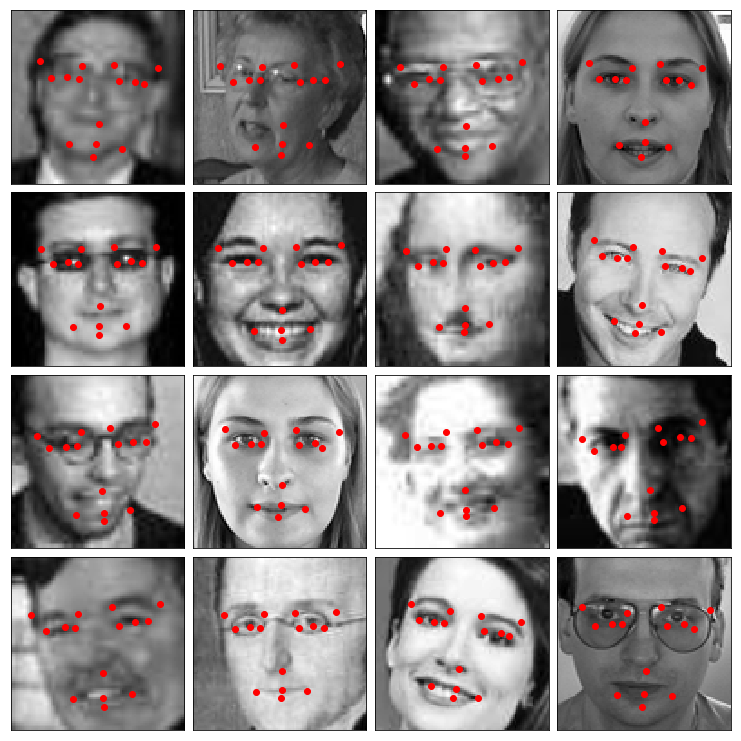

In [50]:
plot_sample(test_sample, pred_sample)

## Kaggle Output

In [52]:
#Predict values for your chosen model
pred = model3.predict(test_data)

In [53]:
# Get the list of required test points
lookup = pd.read_csv('IdLookupTable.csv')

In [54]:
#Match up the test points with the predicted values

labelNums = {}
for index, label in enumerate(train.columns.values):
    labelNums[label] = index
    
lookup['FeatureNum'] = lookup.apply(lambda row: labelNums[row['FeatureName']], axis=1)
lookup.Location =  np.minimum(96,np.maximum(0,pred[lookup.ImageId-1,lookup.FeatureNum]*48 + 48))

In [55]:
# save the rowid and the associated location to a csv

lookup.to_csv(path_or_buf='kagglesubmission.csv',columns=['RowId','Location'],index=False)

To submit, run:
kaggle competitions submit -c facial-keypoints-detection -f submission.csv -m "Message"

# Conclusion

Put a conclusion here comparing and contrasting the models and how well we did on Kaggle

## Summary Table

In [56]:
result_dict['Idx Values'] = ['Training RMSE', 'Development RMSE', 'Training Time (s)']
summary = pd.DataFrame.from_dict(result_dict)
summary = summary.set_index(['Idx Values'])

summary

ValueError: arrays must all be same length

# Sources

 - http://deeplearning.net/tutorial/lenet.html#lenet
 - https://arxiv.org/abs/1206.5533
 - https://arxiv.org/abs/1412.6980v8
 - http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/

# Appendix

### Daniel Nouri model transferred to Keras (as best as I could)

DEADLINE --> Wednesday

- Reorg - Alex
- Step 1 - Research question/Intro
    - how can we accurately predict pixel locations of facial keypoints?
    - map out high level plan of attack
- Step 2 - EDA
    - Explore data - all
    - examining edge cases - Mark
    - Make decisions on NA values, data to keep - Mark
        - to think about --> possibly doing augmentations on portions on the dataset for development
    - Explanation of why we are using a custom loss function rather than filling NA values with some guess at the feature location - all
- Step 3 - Feature engineering/augmentation --> 3-4 augmentations maximum
    - Prepocess
        - gaussian blur --> yes - Tennison
    - Augmentation
        - Flip images --> yes - Alex
        - darken and lighten (either this or normalize) - Tennison
        - rotate --> maybe - Tennison/Maddie
        - Zooming/cropping --> maybe
    - try to correct errors from simple models
- Step 4 - Define success
    - train on simple models for baseline comparison
        - 'DecisionTree': DecisionTreeRegressor(), # Maddie
        - 'NearestNeighbors': KNeighborsRegressor(), # Tennison
        - 'NaiveBayes': NaiveBayes(), # Mark
        - 'LogisticRegression': LogisticRegression() # Alex
        - why did we choose these simple models? - all
            - Everyone choose their own model, not linear regression
            - motivation section
            - run the model
            - why didn't it work?
        - examine how models are handling missing values
        - try augmentations on each model
    - look at error (RMS, absolute, others?) as well as training time
- Step 5 - Examine errors on simple models - all
    - Determine why errors are occurring
- Step 6 - build models
    - train a CNN model on each augmentation
    - Need to explain model hyperparameter choices - Alex/All
        - number of layers
        - number of filters
        - optimizer
        - activation --> 'relu' industry standard
- Step 7 - predict / measure success - all
    - Summary table of performance
    - predict on test data
    - get Kaggle score
    - defeat Trump
- step 8 - site sources - all

In [ ]:
# making a callback so I can compare runtimes
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
model = Sequential()

# first group of layers
model.add(Conv2D(
    32, 
    kernel_size=(3,3), 
    activation='relu',
    input_shape=(96, 96, 1), 
#     data_format='channels_first'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second group of layers
model.add(Conv2D(
    64, 
    kernel_size=(2, 2), 
    activation='relu'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

# third group of layers
model.add(Conv2D(
    128, 
    kernel_size=(2, 2), 
    activation='relu'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(30))

sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

In [ ]:
time_callback = TimeHistory()
hist = model.fit(
    train_data, train_labels, 
    batch_size=32,
    epochs=4,
    validation_split=0.2, 
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('RMS error on validation set:', np.sqrt(hist.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

### Alex trying to understand...

In [ ]:
model = Sequential()

# FIRST CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=32, # don't yet fully understand how to choose this dimension
    kernel_size=(3,3),
    strides=(1,1),
    padding='same',
    activation='relu',
    input_shape=(96, 96, 1),
))
# input_shape = (batch, rows, cols, channels) --> (batch, 96, 96, 1)
# padding = 'same' so for a kernel of size (3,3) and strides=(1,1) this 
# will pad two rows and two columns of zeros on the edges so that the 
# output shape gives an tensor with 96 rows and 96 columns
# output_shape = (batch, new_rows, new_cols, filters) --> (batch, 96, 96, 32)

# POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=None
))
# setting strides=None sets the strides to a default of pool_size, so 
# here we are really setting strides=(2,2) which is what we want so we 
# don't miss any pixels and we don't count any pixels more than once
# the strides is essentially the factor by which to downscale the output
# so setting the strides=(2,2) will have the dimensions of input
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 48, 48, 32)


# SECOND CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=64, # don't know why we increased this number by 2
#     kernel_size=(2, 2),
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu'
))
# input_shape = (batch, pool_rows, pool_cols, in_filters) --> (batch, 48, 48, 32)
# output_shape = (batch, new_rows, new_cols, out_filters) --> (batch, 48, 48, 64)

# SECOND POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2, 2), 
    strides=None
))
# input_shape = (batch, in_rows, in_cols, filters) --> (batch, 48, 48, 64)
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 24, 24, 64)

# THIRD CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=128, # don't know how to choose this value
#     kernel_size=(2, 2),
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu'
))
# input_shape = (batch, pool_rows, pool_cols, in_filters) --> (batch, 24, 24, 64)
# output_shape = (batch, new_rows, new_cols, out_filters) --> (batch, 24, 24, 128)

# THIRD POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=None
))
# input_shape = (batch, in_rows, in_cols, filters) --> (batch, 24, 24, 128)
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 12, 12, 128)

# FLATTEN THE POOLED OUTPUT TO CLASSIFY
model.add(Flatten())
# flatten the output into a single layer of 
#     shape = [batch, pool_rows * pool_cols * in_filters]
#         --> [batch, 12 * 12 * 128] = [batch, 18432]

# ADD ONE FULLY CONNECTED LAYER TO PROCESS THE FLATTENED DATA
model.add(Dense(
#     500,
    1000,
    activation='relu'
))
# input_shape = [batch, flattened_nodes] = [batch, 18432]
# output_shape = [batch, out_nodes] = [batch, 500]

# FINAL OUTPUT LAYER
model.add(Dense(30))
# input_shape = [batch, in_nodes] = [batch, 500]
# output_shape = [batch, num_classes] = [batch, 30]

# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=Adam)

In [ ]:
time_callback = TimeHistory()
hist = model.fit(
    train_data, train_labels, 
    batch_size=32,
    epochs=4, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('\nRMS error on validation set:', np.sqrt(hist.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

Changed the kernel size in the second two layers to (3,3), almost doubled the training time, didn't improve the error by a lot

In [ ]:
# move this cell closer to the top, but putting it here now for convenience in referencing for cell below.
i = 0
feature_dict = {}
for label in train.columns[:-1].values:
# for label in features:
    feature_dict[label] = i
    i += 1
print(feature_dict)

In [ ]:
# Naive baseline - calculate the average (X, Y) of all the labels and 
# guess that every time
n_rows = train_data.shape[0]
n_cols = train_data.iloc[0].shape[0]

for col in [1]: #range(n_cols):
    sum = 0
    for row in range(n_rows):
        sum += train_labels.iloc[row][col]
    avg = sum / n_rows
    predictions = np.ones(dev_data.shape[0]) * avg

    mse = mean_squared_error(dev_labels['left_eye_center_x'], predictions)
    print(mse)

## Grid Search

In [ ]:
# Define the model as a KerasRegressor class

model = KerasRegressor(build_fn=build_CNN, epochs=10)

# Define parameter ranges over which to search

f = list(range(8,72,8))
filts = [[i, i*2, i*4] for i in f]
filts, len(filts)

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

k1 = [[(i,i)]*3 for i in range(2,5)]
k2 = [
    [(4,4), (3,3), (2,2)], 
    [(3,3), (2,2), (2,2)], 
    [(2,2), (3,3), (4,4)],
    [(2,2), (2,2), (3,3)],
    [(3,3), (3,3), (2,2)],
    [(2,2), (3,3), (3,3)],
]
k = k1 + k2
k, len(k)

# param_grid = dict(optimizer=optimizer, filters=filts, kernels=k)
# param_grid = dict(optimizer=optimizer, kernels=k)
param_grid = dict(kernels=k)
param_grid

# Run the grid search

grid = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
#     n_jobs=-1,
    scoring='neg_mean_squared_error',
)

grid_data, grid_labels = shuffle(train_data_set, train_labels_set, random_state=666)
grid_data, grid_labels = grid_data[:100], grid_labels[:100]
grid_data.shape, grid_labels.shape

grid_result = grid.fit(grid_data, grid_labels, verbose=1)

# Get the results and store to csv

cv_results = pd.DataFrame(grid_result.cv_results_)
cv_results.head()
cv_results.to_csv('grid_search_results2.csv')
grid_result.best_params_

## Lighten/Darken Images

In [ ]:
# From here: https://en.wikipedia.org/wiki/Normalization_(image_processing)
def normalize_image(data, min = 0, max = 255):

    new_dataset = []
    split_data = np.split(data, data.shape[0])
    
    for image in split_data:
        image = np.squeeze(image)
        
        image = image * 255
        
        old_min, old_max, old_avg = np.amin(image), np.amax(image), np.mean(image)        
        new_min, new_max, new_avg = min, max, max-min/2
        
        mfactor = old_avg/new_avg

        new_image = []
        
        for pixel in image.flatten():
            #new_pixel = int((pixel-old_min)*((new_max-new_min)/(old_max-old_min))+ new_min)
            new_pixel = pixel * mfactor
            new_image.append(new_pixel)
        
        new_image = np.array(new_image)/ 255
        new_image = new_image.reshape(96, 96, 1)
        
        new_dataset.append(new_image)
    
    return np.stack(new_dataset, axis=0 )

train_data_normalized = normalize_image(train_data)
test_data_normalized = normalize_image(test_data)

f, axarr = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

print (train_data[1].flatten())
print (train_data_normalized[1].flatten())

axarr[0].imshow(train_data[1].reshape(96,96), cmap='gray')
axarr[1].imshow(train_data_normalized[1].reshape(96,96), cmap='gray')

In [ ]:
# Test for augmentation

image = np.squeeze(crop_data[2])

print (image.shape)

plt.figure()
plt.imshow(image, cmap='gray')

#for c in range(0, crop_labels.shape[1], 2):
#    x = crop_labels[111][c]* 48 + 48
#    y = crop_labels[111][c+1]* 48 + 48
        
#    plt.scatter(x,y,cmap='pastel1')

In [ ]:
images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
print (images.shape)

In [ ]:
# additional interesting cases to explore if time allows:
# - multiple faces in one image
# - upside down faces
# - incomplete faces (not all key points present)
# - race/lighting (average shade of pixels in facial region, plot couple darkest/lightest)
# - faces halfway offscreen/covered (could try one eye present, one not), image 154 has eyes and nose but mouth offscreen
# - additonal edge cases discovered incidentally 
#    - sunglasses (1802)

#  - eventually will want to manually remove 2153, 4971 is questionable depending on which points those are

# edge_cases.extend((train_labels[:,feature_dict['right_eye_center_x']] -
#                    train_labels[:,feature_dict['left_eye_center_x']]).argsort()[-7:]) # small faces

In [ ]:
# # original data, no missing values (for training the sklearn baseline models)
# train_data_complete = train_data_complete
# train_labels_complete = train_labels_complete
# dev_data_complete = dev_data_complete
# dev_labels_complete = dev_labels_complete

# # original data with missing values (for first pass of CNN)
# train_data_orig = train_data
# train_labels_orig = train_labels
# dev_data_orig = dev_data
# dev_labels_orig = dev_labels

In [ ]:
# ALEX: The guess-the-average baseline was breaking so I modifed it here
# and moved the original to the appendix. If we want to keep this we 
# probably want to do somethign smarter with the NA's rather than just 
# drop them

    # Convert arrays of arrays to a numpy matrix or sklearn .fit doesn't like them.
#     X = np.empty((train_data.shape[0], train_data.iloc[0].shape[0]))
#     for row in range(train_data.shape[0]):
#         X[row,:] = train_data.iloc[row]
#     Z = np.empty((dev_data.shape[0], dev_data.iloc[0].shape[0]))
#     for row in range(dev_data.shape[0]):
#         Z[row,:] = dev_data.iloc[row]

In [ ]:
flipped_dev_data, flipped_dev_labels = mirror_data(
    dev_data_orig, dev_labels_orig, list(feature_dict.keys())
)

flipped_dev_data_complete, flipped_dev_labels_complete = mirror_data(
    dev_data_complete, dev_labels_complete, list(feature_dict.keys())
)


dev_data_aug = np.concatenate(
    (dev_data_orig,
     flipped_dev_data, 
     contrast_dev_data, 
     blur_dev_data, 
     rotate_dev_data), 
    axis=0
)
dev_labels_aug = np.concatenate(
    (dev_labels_orig, 
     flipped_dev_labels, 
     contrast_dev_labels, 
     blur_dev_labels, 
     rotate_dev_labels), 
    axis=0
    
)


dev_data_aug_comp = np.concatenate(
    (dev_data_complete,
     flipped_dev_data_complete, 
     contrast_dev_data_complete, 
     blur_dev_data_complete, 
     rotate_dev_data_complete), 
    axis=0
)
dev_labels_aug_comp = np.concatenate(
    (dev_labels_complete,
     flipped_dev_labels_complete, 
     contrast_dev_labels_complete, 
     blur_dev_labels_complete, 
     rotate_dev_labels_complete
    ), 
    axis=0
)

In [20]:
# delete all single augmentation sets to preserve memory
del flipped_data, contrast_data, blur_data, rotate_data, flipped_labels, contrast_labels, blur_labels, rotate_labels, flipped_dev_data, contrast_dev_data, blur_dev_data, rotate_dev_data,flipped_dev_labels, contrast_dev_labels, blur_dev_labels, rotate_dev_labels,flipped_data_complete, contrast_data_complete, blur_data_complete, rotate_data_complete,flipped_labels_complete, contrast_labels_complete, blur_labels_complete, rotate_labels_complete,contrast_dev_data_complete, blur_dev_data_complete, rotate_dev_data_complete,flipped_dev_labels_complete, contrast_dev_labels_complete, blur_dev_labels_complete, rotate_dev_labels_complete

NameError: name 'contrast_data' is not defined